In [1]:
import kagglehub
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import os

# configuracao para ignorar avisos
warnings.filterwarnings('ignore')

# download e carregamento do dataset
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(fr'{path}/adult.csv')

Using Colab cache for faster access to the 'adult-income-dataset' dataset.
Path to dataset files: /kaggle/input/adult-income-dataset


In [2]:
def prepocessing(df):
    # remove colunas desnecessarias
    df.drop(columns=['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week'], inplace = True)

    # filtra linhas com valores faltantes representados por interrogacao
    fill_rows = ~(df == '?').any(axis = 1)
    df = df[fill_rows]

    # converte variaveis categoricas em numericas
    for col in df.columns:
        if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
          df[col], _ = pd.factorize(df[col])

    return df

def split_train_test(df, test_size=0.3):
    # embaralha o dataframe aleatoriamente
    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # calcula o indice de corte para a divisao
    len_df = len(shuffled_df)
    cut_point = len_df - round(len_df * test_size)

    # realiza a divisao entre treino e teste
    train = shuffled_df[:cut_point]
    test = shuffled_df[cut_point:]

    print(f'Tamanho total: {len(df)}')
    print(f'Tamanho do treino: {len(train)}')
    print(f'Tamanho do teste: {len(test)}')

    return train, test

In [3]:
class KNN_DP():
    def __init__(self, r):
        # inicializa o raio de busca
        self.r = r
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        # armazena os dados de treino convertidos para float
        self.X_train = np.array(X, dtype=np.float32)
        self.y_train = np.array(y)

    def get_vizinhos_indices(self, test_row):
        # calcula a distancia euclidiana ao quadrado e filtra pelo raio
        diferencas = self.X_train - test_row
        dist_sq = np.sum(diferencas ** 2, axis=1)
        indices = np.where(dist_sq <= self.r ** 2)[0]
        return indices

    def predict_instance(self, test_row):
        # realiza a predicao tradicional por voto majoritario
        indices = self.get_vizinhos_indices(test_row)

        if len(indices) == 0:
            return np.random.choice(self.y_train)

        classes_vizinhas = self.y_train[indices]
        valores, contagens = np.unique(classes_vizinhas, return_counts=True)
        return valores[np.argmax(contagens)]

    def predict(self, X_test):
        # aplica a predicao tradicional para todo o conjunto de teste
        X_test = np.array(X_test, dtype=np.float32)
        return np.array([self.predict_instance(x) for x in X_test])

    def predict_instance_private_exponential(self, test_row, epsilon):
        # implementa o mecanismo exponencial para escolha da classe
        indices = self.get_vizinhos_indices(test_row)

        if len(indices) == 0:
            return np.random.choice(self.y_train)

        classes_vizinhas = self.y_train[indices]
        classes_possiveis = np.unique(self.y_train)

        contagens = {cls: 0 for cls in classes_possiveis}
        for cls in classes_vizinhas:
            contagens[cls] += 1

        delta_u = 1

        utilities = np.array([
            (epsilon * contagens[cls]) / (2 * delta_u)
            for cls in classes_possiveis
        ])

        utilities -= np.max(utilities)

        probs = np.exp(utilities)
        probs /= np.sum(probs)

        return np.random.choice(classes_possiveis, p=probs)

    def predict_private_exponential(self, X_test, epsilon):
        # divide o orcamento de privacidade pelo tamanho do teste e faz a predicao
        X_test = np.array(X_test, dtype=np.float32)
        n_test_samples = len(X_test)
        epsilon_individual = epsilon / n_test_samples
        return np.array([
            self.predict_instance_private_exponential(x, epsilon_individual)
            for x in X_test
        ])

In [4]:
# executa as funcoes de limpeza e divisao dos dados
df = prepocessing(df)
X_train, X_test = split_train_test(df)

# separa as variaveis preditoras x da variavel alvo y
y_train = X_train['age'].values
x_train = X_train.drop(columns=['age']).values

y_test = X_test['age'].values
x_test = X_test.drop(columns=['age']).values

# define os parametros de raio e epsilon para os experimentos
raios = [1, 3, 6, 9]
epsilons = [0.1, 0.5, 1, 5, 10, 100]

Tamanho total: 45222
Tamanho do treino: 31655
Tamanho do teste: 13567


In [5]:
# loop para treinar e testar o modelo com diferentes parametros
for r in raios:
    print(f"Executando r-NN com raio r = {r}")


    model = KNN_DP(r=r)
    model.fit(x_train, y_train)

    # executa e salva o r nn tradicional
    y_pred_trad = model.predict(x_test)

    df_trad = pd.DataFrame({
        'y_true': y_test,
        'y_pred': y_pred_trad
    })

    nome_trad = f'resultado_rNN_tradicional_r_{r}.csv'
    df_trad.to_csv(nome_trad, index=False)
    print(f"Arquivo salvo: {nome_trad}")

    # executa e salva o r nn com mecanismo exponencial
    for eps in epsilons:
        print(f"  Executando versão privada (eps={eps})")

        y_pred_priv = model.predict_private_exponential(
            x_test, epsilon=eps
        )

        df_priv = pd.DataFrame({
            'y_true': y_test,
            'y_pred': y_pred_priv
        })

        nome_priv = f'resultado_rNN_exponencial_r_{r}_eps_{eps}.csv'
        df_priv.to_csv(nome_priv, index=False)
        print(f"  Arquivo salvo: {nome_priv}")

print("\nProcesso finalizado.")

Executando r-NN com raio r = 1
Arquivo salvo: resultado_rNN_tradicional_r_1.csv
  Executando versão privada (eps=0.1)
  Arquivo salvo: resultado_rNN_exponencial_r_1_eps_0.1.csv
  Executando versão privada (eps=0.5)
  Arquivo salvo: resultado_rNN_exponencial_r_1_eps_0.5.csv
  Executando versão privada (eps=1)
  Arquivo salvo: resultado_rNN_exponencial_r_1_eps_1.csv
  Executando versão privada (eps=5)
  Arquivo salvo: resultado_rNN_exponencial_r_1_eps_5.csv
  Executando versão privada (eps=10)
  Arquivo salvo: resultado_rNN_exponencial_r_1_eps_10.csv
  Executando versão privada (eps=100)
  Arquivo salvo: resultado_rNN_exponencial_r_1_eps_100.csv
Executando r-NN com raio r = 3
Arquivo salvo: resultado_rNN_tradicional_r_3.csv
  Executando versão privada (eps=0.1)
  Arquivo salvo: resultado_rNN_exponencial_r_3_eps_0.1.csv
  Executando versão privada (eps=0.5)
  Arquivo salvo: resultado_rNN_exponencial_r_3_eps_0.5.csv
  Executando versão privada (eps=1)
  Arquivo salvo: resultado_rNN_exponen

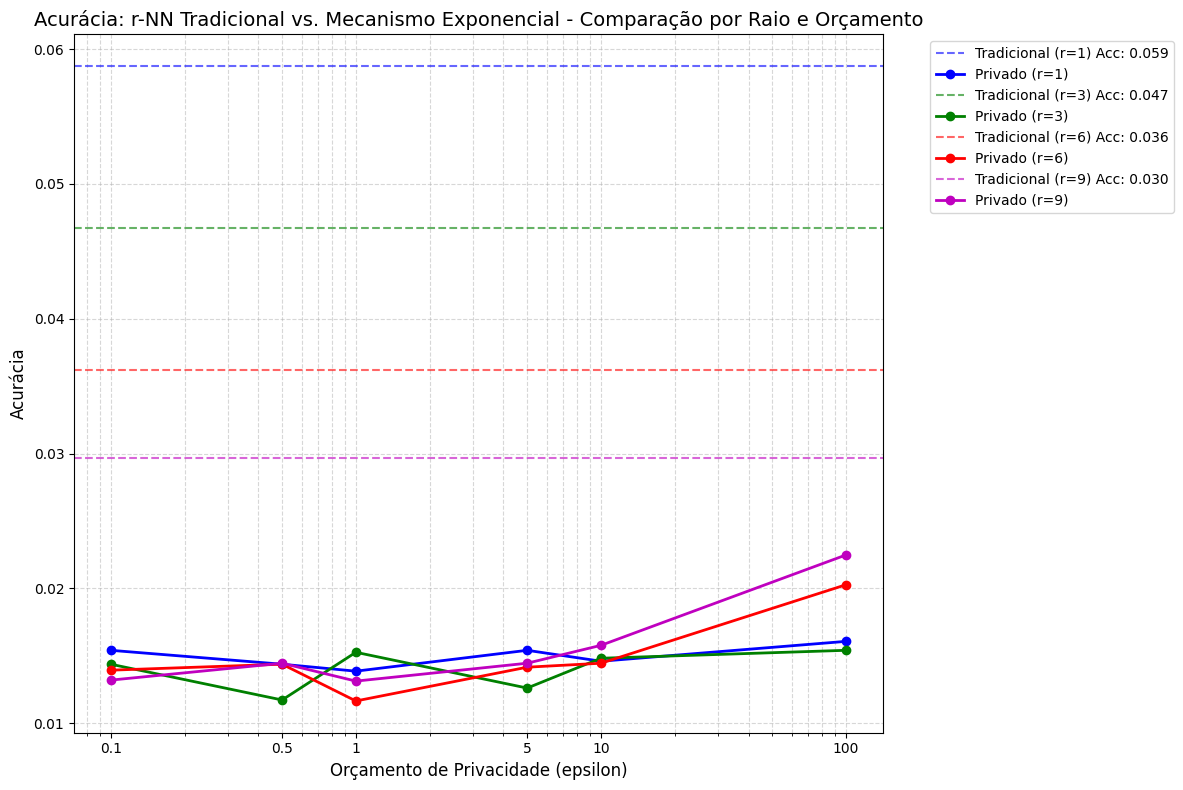

In [7]:
# funcao auxiliar para calcular acuracia
def acuracia(pred, y_target):
    return sum(pred == y_target)/len(y_target)

# listas de parametros
raios = [1, 3, 6, 9]
epsilons = [0.1, 0.5, 1, 5, 10, 100]

# configuracao do grafico
plt.figure(figsize=(12, 8))
cores = ['b', 'g', 'r', 'm'] # cores diferentes para cada raio

# loop para processar cada raio
for i, r in enumerate(raios):
    cor = cores[i % len(cores)] # garante que nao falte cor

    # 1. processar baseline (r-nn tradicional)
    nome_trad = f'resultado_rNN_tradicional_r_{r}.csv'
    acc_trad = 0
    if os.path.exists(nome_trad):
        df_trad = pd.read_csv(nome_trad)
        acc_trad = acuracia(df_trad['y_pred'].values, df_trad['y_true'].values)

        # plota linha tracejada horizontal para o baseline deste raio
        plt.axhline(y=acc_trad, color=cor, linestyle='--', alpha=0.6,
                    label=f'Tradicional (r={r}) Acc: {acc_trad:.3f}')
    else:
        print(f"Aviso: Arquivo {nome_trad} não encontrado.")

    # 2. processar curva privada (mecanismo exponencial)
    acuracias_privadas = []
    for eps in epsilons:
        nome_priv = f'resultado_rNN_exponencial_r_{r}_eps_{eps}.csv'

        if os.path.exists(nome_priv):
            df_priv = pd.read_csv(nome_priv)
            acc = acuracia(df_priv['y_pred'].values, df_priv['y_true'].values)
            acuracias_privadas.append(acc)
        else:
            print(f"Aviso: Arquivo {nome_priv} não encontrado.")
            acuracias_privadas.append(0)

    # plota a curva continua para o metodo privado deste raio
    plt.plot(epsilons, acuracias_privadas, marker='o', linestyle='-',
             color=cor, linewidth=2, label=f'Privado (r={r})')

# formatacao final do grafico
plt.title('Acurácia: r-NN Tradicional vs. Mecanismo Exponencial - Comparação por Raio e Orçamento', fontsize=14)
plt.xlabel('Orçamento de Privacidade (epsilon)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)

# ajusta escala x para logaritmica para melhor visualizacao dos pontos
plt.xscale('log')
plt.xticks(epsilons, labels=[str(e) for e in epsilons]) # força os labels exatos

plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # legenda fora para nao poluir
plt.tight_layout()

plt.savefig('grafico_comparativo_final_todos_raios.png')
plt.show()